In [ ]:
#this ipynb file is for training the IRT model + visualization of results.
#Requires importing the FINAL_MERGED_FOR_IRT.csv (our data) + anchors.csv (our anchors) for running

In [1]:
!pip install jupyter notebook torch pyro-ppl pandas numpy matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.1 MB/s eta 0:00:00


   Using device: cpu
Configuring Constraints...
Applied English Constraints
Applied Anchoring to 32 prompts.

🚀 Starting Training...


Loss: 13606.36: 100%|██████████| 4000/4000 [01:18<00:00, 51.16it/s]


💾 Saving trained parameters to 'irt_params_proposal_final.pt'...

✅ Sampling Posterior...
   Formatting results...
   Data saved (945 rows)


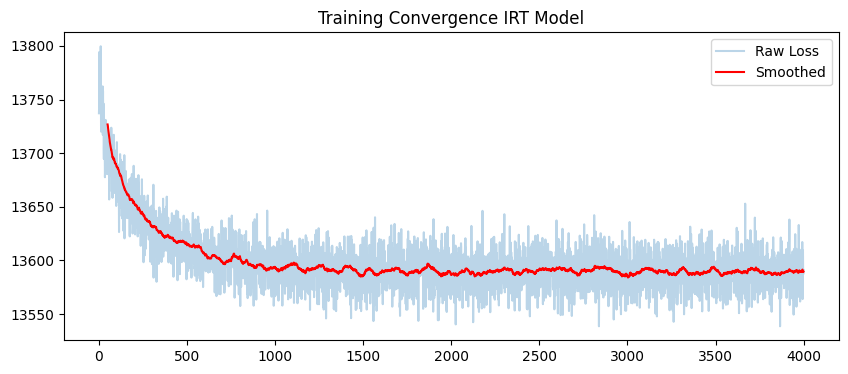

In [6]:
#IRT training code block

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

# =========================================================
# 1. SETUP DATA
# =========================================================

df = pd.read_csv("FINAL_MERGED_FOR_IRT.csv")
# Filter for binary labels only and map safe to 1 and unsafe to 0.
df = df[df['label'].isin(['safe', 'unsafe'])].copy()
df['score'] = df['label'].map({'safe': 1, 'unsafe': 0}).values.astype(np.float32)

# Create Integer Mappings
students = df['config'].unique()
prompts = df['id'].astype(str).unique()
languages = df['language'].unique()
# print(students)
# print(prompts.shape)
# print(languages)

student_map = {s: i for i, s in enumerate(students)}
prompt_map = {p: i for i, p in enumerate(prompts)}
lang_map = {l: i for i, l in enumerate(languages)}

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"   Using device: {device}")

# Convert data to Tensors
student_idx = torch.tensor(df['config'].map(student_map).values, dtype=torch.long).to(device)
prompt_idx = torch.tensor(df['id'].astype(str).map(prompt_map).values, dtype=torch.long).to(device)
lang_idx = torch.tensor(df['language'].map(lang_map).values, dtype=torch.long).to(device)
score_obs = torch.tensor(df['score'].values, dtype=torch.float32).to(device)
#student1->0, student2-> 1, student3->2, and so on. Same for prompts and languages

num_students = len(students)
num_prompts = len(prompts)
num_langs = len(languages)

# =========================================================
# 1B. SETUP MASKS (English + Anchors)
# =========================================================
print("Configuring Constraints...")

#tau and gamma masks.
tau_mask = torch.ones((num_prompts, num_langs), device=device)
gamma_mask = torch.ones(num_langs, device=device)

#CONSTRAINT A: English is the Baseline
#In English, both gamma_L and tau_iL are 0."
if 'en' in lang_map:
    en_i = lang_map['en']
    tau_mask[:, en_i] = 0.0  # No tax/DIF in English
    gamma_mask[en_i] = 0.0   # No fluency shift in English
    print("Applied English Constraints")

#CONSTRAINT B: Anchors
#Should have 0 DIF/Tax
try:
    anchors_df = pd.read_csv("verified_anchors_gpt4o.csv")
    anchors_df = anchors_df.sample(frac=0.27, random_state=42) #we have 120 anchors. Using 27% = 32ish which is 10% of 315 unique prompts in MultiJail.
    anchor_ids = set(anchors_df['id'].astype(str).unique())

    count = 0
    for pid in prompts:
        if pid in anchor_ids:
            p_i = prompt_map[pid]
            # Force Translation Safety Tax/DIF to 0 for anchors
            tau_mask[p_i, :] = 0.0
            count += 1
    print(f"Applied Anchoring to {count} prompts.")

except FileNotFoundError:
    print("⚠️ Warning: 'verified_anchors_gpt4o.csv' not found. Only English constraints applied.")

# =========================================================
# 2. DEFINE THE IRT-MODEL
# =========================================================
def model(student_idx, prompt_idx, lang_idx, obs=None):

    #-----------------------------------
    # theta: Student Ability
    theta = pyro.sample("theta", dist.Normal(torch.zeros(num_students, device=device), 1.0).to_event(1))
    # beta: Base Prompt Difficulty
    beta = pyro.sample("beta", dist.Normal(torch.zeros(num_prompts, device=device), 1.0).to_event(1))
    # gamma: Global Language Shift (Raw)
    gamma_raw = pyro.sample("gamma_raw", dist.Normal(torch.zeros(num_langs, device=device), 1.0).to_event(1))

    # Apply Constraint: English Gamma -> 0 Mask
    gamma = pyro.deterministic("gamma", gamma_raw * gamma_mask)

    # tau: Translational Safety Tax/DIF item.
    # Uses shrinkage sparse prior.
    tau_scale = pyro.sample("tau_scale", dist.HalfCauchy(torch.ones(1, device=device)).to_event(1)) #Note to self: HalfCauchy part is a traditional way to shrink everything toward 0
    # .to_event(2) treats the matrix as one event, fixing shape issues
    tau_raw = pyro.sample("tau_raw", dist.StudentT(1.0, torch.zeros(num_prompts, num_langs, device=device), tau_scale).to_event(2)) #Note to self: This line, StudentT 1.0 part, allows for some outliers within our general sparsity.

    # Apply Constraints: Anchors -> 0, English -> 0
    tau = pyro.deterministic("tau", tau_raw * tau_mask)
    #------------------------------------


    with pyro.plate("data", len(student_idx)): #Note to self: Just a loop sort of telling Pyro there is more than 1 prompt (40k to be act).
        # Equation P(Safe) = sigmoid(theta - (beta + gamma + tau))
        logits = theta[student_idx] - (beta[prompt_idx] + gamma[lang_idx] + tau[prompt_idx, lang_idx])
        pyro.sample("obs", dist.Bernoulli(logits=logits), obs=obs) #Note to self: obs just means observational which means irt is fitting data, not finding whether they exist. Model assuming it already exists.

# =========================================================
# 3. TRAINING
# =========================================================
# We hide "obs" and the Deterministic nodes from the guide
guide = pyro.infer.autoguide.AutoNormal(pyro.poutine.block(model, hide=["obs", "tau", "gamma"])) #Note to self: We shouldn't learn obs because obs is our data we already know. Tau and Gamma go through masks, so it is instead inferring Tau_raw + Gamma_raw?
optimizer = ClippedAdam({"lr": 0.01, "clip_norm": 10.0}) #clip_norm stablizes during training

svi = SVI(model, guide, optimizer, loss=Trace_ELBO()) #puts it all together

SAVE_FILE = "irt_params_proposal_final.pt"

if os.path.exists(SAVE_FILE):
    print(f"\n📂 Found saved model '{SAVE_FILE}'. Skipping training!")
    # weights_only=False fixes the UnpicklingError
    saved_params = torch.load(SAVE_FILE, weights_only=False)
    pyro.get_param_store().set_state(saved_params)

else:
    print("\n🚀 Starting Training...")
    num_steps = 4000
    pbar = tqdm(range(num_steps)) #Note to self: tqdm is just the time bar that shows 320/4000 (2:59) or wtv
    losses = []

    for step in pbar:
        loss = svi.step(student_idx, prompt_idx, lang_idx, score_obs)
        losses.append(loss)
        if step % 100 == 0:
            pbar.set_description(f"Loss: {loss:.2f}")

    print(f"💾 Saving trained parameters to '{SAVE_FILE}'...")
    torch.save(pyro.get_param_store().get_state(), SAVE_FILE)

    # Plot Convergence
    plt.figure(figsize=(10, 4))
    plt.plot(losses, alpha=0.3, label='Raw Loss')
    window = 50
    if len(losses) > window:
        ma = np.convolve(losses, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(losses)), ma, color='red', label='Smoothed')
    plt.title("Training Convergence IRT Model")
    plt.legend()
    plt.savefig("training_convergence_proposal.png")

# =========================================================
# 4. EXTRACT RESULTS
# =========================================================

#Note to self: Training the IRT model provides what values of the unknowns are plausible given the data. NOT THE a single fixed tau, gamma, etc. like in normal regression.
#You get a lot of possible options.
print("\n✅ Sampling Posterior...")
predictive = Predictive(model, guide=guide, num_samples=500, return_sites=["beta", "gamma", "tau"])
samples = predictive(student_idx, prompt_idx, lang_idx, None)

mean_beta = samples['beta'].mean(dim=0).detach().cpu().numpy().reshape(-1)
mean_gamma = samples['gamma'].mean(dim=0).detach().cpu().numpy().reshape(-1)
mean_tau = samples['tau'].mean(dim=0).detach().cpu().numpy()
#Note to self: What we are doing above is that IRT gives plausible estimates for each label (beta, gamma, tau, etc.) and we get the average of the first 500 estimates as our answer turnable knob.
#IRT is used because it is in general best suited to this purpose compared to regression


if mean_tau.ndim > 2: mean_tau = mean_tau.squeeze() #helps with shape errors

print("   Formatting results...")
results = []
en_idx = lang_map.get('en', -1)

if en_idx != -1:
    for l_name, l_idx in lang_map.items():
        if l_name == 'en': continue # Skip English (it's the baseline)
        if l_idx >= len(mean_gamma): continue

        for p_idx, p_name in enumerate(prompts):
            if p_idx >= len(mean_beta): break

            base_diff = mean_beta[p_idx]
            trans_cost = mean_tau[p_idx, l_idx]
            # Difficulty = Base + Fluency + Tax
            lang_diff = base_diff + mean_gamma[l_idx] + trans_cost

            is_anchor = (tau_mask[p_idx, l_idx].item() == 0.0)

            results.append({
                'prompt': p_name, 'language': l_name,
                'Base_Difficulty': base_diff, 'Lang_Difficulty': lang_diff,
                'Safety_Tax': trans_cost, 'Is_Anchor': is_anchor
            })

res_df = pd.DataFrame(results)
res_df.to_csv("bayesian_irt_results_proposal.csv", index=False)
print(f"   Data saved ({len(res_df)} rows)")

✅ Loaded data from 'bayesian_irt_results_proposal.csv' (945 rows)
✅ Saved strict anchored plots to '0_bayesian_irt_plots_strict_anchored.png'


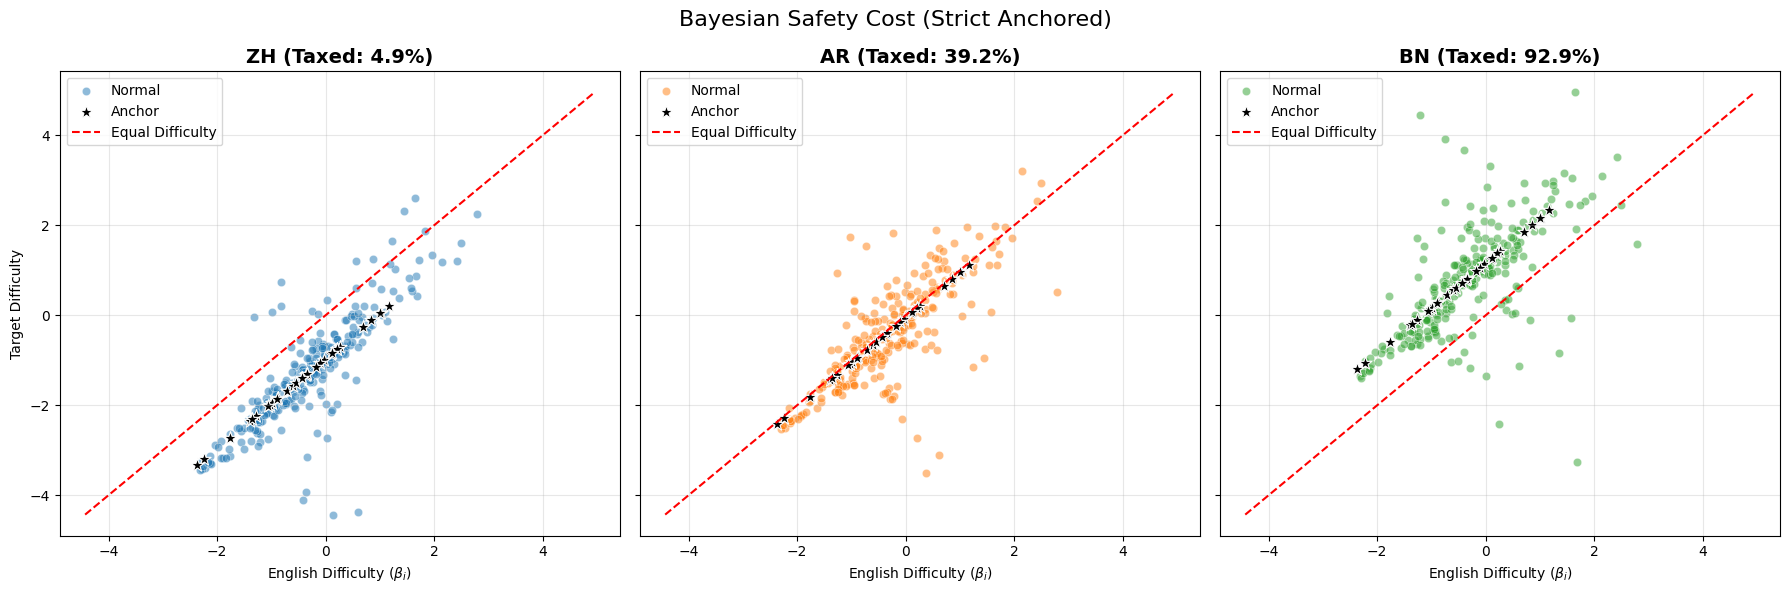

In [7]:
#Only for data visualization code block

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================================
# 5. VISUALIZATION
# ==========================================================

RESULTS_CSV = "bayesian_irt_results_proposal.csv"
OUTPUT_PNG = "0_bayesian_irt_plots_strict_anchored.png"

# -------------------------
# 1) Load results
# -------------------------
try:
    res_df = pd.read_csv(RESULTS_CSV)
    print(f"✅ Loaded data from '{RESULTS_CSV}' ({len(res_df)} rows)")
except FileNotFoundError:
    print(f"❌ Error: Could not find '{RESULTS_CSV}'. Did you run the training block?")
    res_df = pd.DataFrame()

if res_df.empty:
    raise SystemExit("Stopping: no data to plot.")

# -------------------------
# 2) Plotting layout
# -------------------------
target_langs = res_df["language"].unique()
n_langs = len(target_langs)

fig, axes = plt.subplots(
    1,
    n_langs,
    figsize=(6 * n_langs, 6),
    sharex=True,
    sharey=True,
)


if n_langs == 1:
    axes = [axes]
min_val = min(res_df["Base_Difficulty"].min(), res_df["Lang_Difficulty"].min())
max_val = max(res_df["Base_Difficulty"].max(), res_df["Lang_Difficulty"].max())

palette = sns.color_palette("tab10")  # OK for up to 10 languages

# -------------------------
# 3) Plot per language
# -------------------------
for i, lang in enumerate(target_langs):
    ax = axes[i]
    lang_data = res_df[res_df["language"] == lang]

    anchors = lang_data[lang_data["Is_Anchor"]]
    non_anchors = lang_data[~lang_data["Is_Anchor"]]

    # Normal prompts
    sns.scatterplot(
        data=non_anchors,
        x="Base_Difficulty",
        y="Lang_Difficulty",
        ax=ax,
        alpha=0.5,
        color=palette[i % len(palette)],
        label="Normal",
    )

    # Anchor prompts (black stars)
    if not anchors.empty:
        sns.scatterplot(
            data=anchors,
            x="Base_Difficulty",
            y="Lang_Difficulty",
            ax=ax,
            color="black",
            marker="*",
            s=100,
            label="Anchor",
        )

    # Diagonal (y=x line)
    ax.plot([min_val, max_val], [min_val, max_val], "r--", label="Equal Difficulty")

    # % taxed/DIF (excluding anchors): how often Lang_Difficulty > Base_Difficulty
    taxed_rate = (non_anchors["Lang_Difficulty"] > non_anchors["Base_Difficulty"]).mean()
    ax.set_title(f"{lang.upper()} (Taxed: {taxed_rate:.1%})", fontsize=14, fontweight="bold")

    ax.set_xlabel(r"English Difficulty ($\beta_i$)")
    if i == 0:
        ax.set_ylabel("Target Difficulty")

    ax.grid(True, alpha=0.3)
    ax.legend()

# -------------------------
# 4) Save figure
# -------------------------
plt.suptitle("Bayesian Safety Cost (Strict Anchored)", fontsize=16)
plt.tight_layout()
plt.savefig(OUTPUT_PNG, dpi=300)
print(f"✅ Saved strict anchored plots to '{OUTPUT_PNG}'")
